Script for performing Multi-Crteria Decision Making analysis to evaluate the huts. Steps:
1. Create the 'alternatives' dataframe by aggregating information on the various criteria (water, energy, etc.)
    
    1.1 convert qualitative data in quantittive using a scoring system

2. perform MCDM analysis with ‘pymcdm` library (compare different methods)

In [82]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
import rasterio
import random

import warnings
warnings.simplefilter("ignore")

In [83]:
def standardize_name(name):
    ''' converts names to lowercase, strips leading and trailing whitespace, 
    and removes non-alphanumeric characters.
    '''
    return ''.join(e for e in name.lower().strip() if e.isalnum())

# Create geodataframe

In [84]:
huts_points = gpd.read_file('../data/huts/huts_points.geojson')
huts_points = huts_points.to_crs(epsg=32632) # convert to UTM32N [m] for analysis
huts_points.head(5)

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,geometry
0,alpepozzavlancia,"ALPE POZZA ""VINCENZO LANCIA""",C,Alp,50,1802,POINT (666584.351 5077095.370)
1,altissimodchiesa,"ALTISSIMO ""DAMIANO CHIESA""",C,Alp,35,2060,POINT (646874.183 5074717.942)
2,antermoia,ANTERMOIA,D,Alp,61,2496,POINT (704489.000 5150499.000)
3,bindesipprati,"BINDESI ""PINO PRATI""",A,Escurs,0,618,POINT (666672.806 5100323.693)
4,boccaditratnpernici,"BOCCA DI TRAT ""NINO PERNICI""",C,Alp,28,1601,POINT (637133.000 5087416.000)


## Water criteria
Source: SAT's archive

Criteria:
- type of water source
- water storage capacity

In [85]:
appr_idrico = pd.read_csv('../data/water/sat_appr_idrico.csv')
# Replace -999 with NaN
appr_idrico.replace(-999, np.nan, inplace=True)
appr_idrico.replace('-999', np.nan, inplace=True)

CR_WA_01. TYPE OF SOURCE

In [86]:
# Merge huts_points with appr_idrico 
merged_df = huts_points.merge(appr_idrico[['standard_name', 'acquedotto', 'sorgente', 'superficiale', 'cisterna_m3']], on='standard_name', how='left')

# Define the function to create the CR_WA_01 column
def determine_CR_WA_01(row):
    if row['acquedotto'] == 1:
        return 'aqueduct'
    elif row['sorgente'] == 1:
        return 'spring'
    elif pd.notna(row['superficiale']):
        if row['superficiale'] == '0':
            return 'nosource'
        return row['superficiale']
    else:
        return np.nan

# Apply the function to create the CR_WA_01 column
merged_df['CR_WA_01'] = merged_df.apply(determine_CR_WA_01, axis=1)
merged_df.CR_WA_01.value_counts()


CR_WA_01
spring       9
aqueduct     6
fusione      6
torr-rio     5
torr-lago    2
lago         2
misto        1
lago-torr    1
nosource     1
Name: count, dtype: int64

CR_WA_02. WATER STORAGE CAPACITY [m3]

In [87]:
def process_cisterna_m3(value):
    try:
        if isinstance(value, str)and '+' in value:
            # split the value by '+' and convert to integers, then sum them
            return sum(map(int, value.split('+')))
        else:
            # convert the value to a float
            return float(value)
    except ValueError:
        # if conversion fails, return NaN
        return np.nan

merged_df['CR_WA_02'] = merged_df['cisterna_m3'].apply(process_cisterna_m3)

## Energy & electricity
Source: SAT's report on energy (2021)

Criteria:
- Type of energy source(s)
- Number of energy sources
- Power storage capacity
- Heating source

In [88]:
appr_energia = pd.read_csv('../data/sat_appr_energetico.csv')
appr_energia.head(5)

,rifugio,categoria_CAISAT,categoria_PAT,quota,posti_letto,cogeneratore,generatore,potenza_gruppoel_kw,riserva,fotovoltaico,potenza_fotov_kw,accumulo_fotov_V,accumulo_fotov_ah,idroelettrico,potenza_idro_kw,rete_elettrica,gas_gpl,solare_termico,riscaldamento,note
0,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,0,1,40,1,1,1.8,24,1500,0,0,0,1,0,gasolio,NaN
1,"Altissimo - ""D.Chiesa""",C,Alp,2.060,35,0,1,20,1,1,2.5,48,1000,0,0,0,1,0,-999,NaN
2,Antermoia,D,Alp,2.496,61,1,0,60,1,1,1.4,24,1580,0,0,0,1,0,gasolio,NaN
3,"Bindesi - ""P.Prati""",A,Escurs.,611.000,0,0,0,0,0,0,0.0,0,0,0,0,1,1,0,-999,NaN
4,"Bocca di Trat - ""N.Pernici""",C,Alp,1.600,28,0,1,40,1,1,1.2,24,1200,0,0,0,1,0,-999,NaN


In [89]:
# Replace -999 with NaN
appr_energia.replace(-999, np.nan, inplace=True)
appr_energia.replace('-999', np.nan, inplace=True)
# Standardize names
appr_energia['standard_name'] = appr_energia['rifugio'].apply(standardize_name)
# fix xii apostoli
appr_energia.loc[appr_energia['standard_name'] == '1iiapostoliflligarbari', 'standard_name'] = 'xiiapostoliflligarbari'

In [90]:
appr_energia.columns

Index(['rifugio', 'categoria_CAISAT', 'categoria_PAT', 'quota', 'posti_letto',
       'cogeneratore', 'generatore', 'potenza_gruppoel_kw', 'riserva',
       'fotovoltaico', 'potenza_fotov_kw', 'accumulo_fotov_V',
       'accumulo_fotov_ah', 'idroelettrico', 'potenza_idro_kw',
       'rete_elettrica', 'gas_gpl', 'solare_termico', 'riscaldamento', 'note',
       'standard_name'],
      dtype='object')

CR_EN_01. TYPE OF SOURCE

In [91]:
# Merge with appr_energia
merged_df = merged_df.merge(appr_energia[['standard_name', 'cogeneratore', 'generatore', 'potenza_gruppoel_kw', 'riserva',
       'fotovoltaico', 'potenza_fotov_kw', 'accumulo_fotov_V',
       'accumulo_fotov_ah', 'idroelettrico', 'potenza_idro_kw',
       'rete_elettrica', 'gas_gpl', 'solare_termico', 'riscaldamento']], 
       on='standard_name', how='left')

def determine_energy(row):
    res = []
    if row['cogeneratore'] == 1:
        res.append('cogenerator')
    if row['generatore'] == 1:
        res.append('generator')
    if row['fotovoltaico'] == 1:
        res.append('photovoltaic')
    if row['idroelettrico'] == 1:
        res.append('hydroelectric')
    if row['rete_elettrica'] == 1:
        res.append('public_electricity')
    if row['gas_gpl'] == 1:
        res.append('gas')
    if row['solare_termico'] == 1:
        res.append('solar_thermal')
    if res == []:
        return np.nan
    else:
        return res

# Apply the function to create the column
merged_df['CR_EN_01'] = merged_df.apply(determine_energy, axis=1)

CR_EN_02. NUMBER OF SOURCES

In [93]:
merged_df['CR_EN_02'] = merged_df['CR_EN_01'].apply(len)

CR_EN_03. POWER STORAGE CAPACITY

In [94]:
# Sum of kw from all sources
# Note: potenza_gruppoel_kw is of type object because it has sums 
def determine_capacity(row):
    res = 0
    for col in ['potenza_gruppoel_kw', 'potenza_fotov_kw', 'potenza_idro_kw']:
        try:
            if isinstance(row[col], str) and '+' in row[col]:
                # split the value by '+' and convert to integers, then sum them
                res += sum(map(int, row[col].split('+')))
            else:
                # convert the value to a float
                res += float(row[col])
        except ValueError:
            return np.nan

    return res

merged_df['CR_EN_03'] = merged_df.apply(determine_capacity, axis=1)

In [95]:
merged_df.CR_EN_03.unique()
# the ones at 0 are the 8 connected to public electricity

array([ 41.8,  22.5,  61.4,   0. ,  41.2,  25. ,  21. ,  40. ,   7. ,
       120. ,   6. ,  43.2,  26.5,   8. ,  29.2,  80. , 840. ,  30. ,
        21.3,  26.3])

CR_EN_04. HEATING

It can be electric or with gpl. Some huts had no data, so I check the electricity sources to see if there are renewables or the public electricity that could be used for heating. 

In [96]:
merged_df['CR_EN_04'] = merged_df['riscaldamento']

In [97]:
for idx, row in merged_df.iterrows():
    if row['CR_EN_04'] != 'elettrico' and row['CR_EN_04'] != 'gasolio':
        energy_sources = row['CR_EN_01']
        renewable_sources = ['hydroelectric', 'solar_thermal', 'photovoltaic']
        ren_options = [source for source in energy_sources if source in renewable_sources]
        # check renewables
        if ren_options:
            print(f"Found a renewable heating option! {ren_options} in {row['standard_name']}")
            merged_df.at[idx, 'CR_EN_04'] = 'renewable_option'
        # check public electricity
        elif 'public_electricity' in energy_sources:
            print(f"Found a public electricity for heating! In {row['standard_name']}")
            merged_df.at[idx, 'CR_EN_04'] = 'public_electricity'

Found a renewable heating option! ['photovoltaic'] in altissimodchiesa
Found a public electricity for heating! In bindesipprati
Found a renewable heating option! ['photovoltaic'] in boccaditratnpernici
Found a renewable heating option! ['photovoltaic'] in casarotalciola
Found a public electricity for heating! In ciampediè
Found a renewable heating option! ['hydroelectric'] in cimadastaobrentari
Found a renewable heating option! ['photovoltaic'] in fftucketteqsella
Found a public electricity for heating! In finonchiofllifilzi
Found a renewable heating option! ['solar_thermal'] in montecalinosanpietro
Found a public electricity for heating! In paludei
Found a renewable heating option! ['photovoltaic', 'solar_thermal'] in peller
Found a renewable heating option! ['photovoltaic'] in rodadivael
Found a renewable heating option! ['hydroelectric'] in stavelfdenza
Found a renewable heating option! ['photovoltaic'] in valdambiezsagostini
Found a renewable heating option! ['hydroelectric'] in va

In [98]:
merged_df['CR_EN_04'].value_counts(dropna=False)

CR_EN_04
renewable_option      14
gasolio                7
elettrico              6
public_electricity     4
NaN                    2
Name: count, dtype: int64

In [99]:
merged_df[merged_df['CR_EN_04'].isna()]

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,geometry,acquedotto,sorgente,superficiale,...,idroelettrico,potenza_idro_kw,rete_elettrica,gas_gpl,solare_termico,riscaldamento,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04
25,tosaetpedrotti,"TOSA ""TOMMASO PEDROTTI""",D,Alp,140,2500,POINT (646611.171 5112931.074),0.0,1.0,0,...,0.0,0.0,0.0,1.0,0.0,NaN,"[cogenerator, gas]",2,80.0,NaN
31,vioz,"VIOZ ""MANTOVA""",E,Alp,60,3531,POINT (625753.000 5139701.000),0.0,0.0,fusione,...,0.0,0.0,0.0,1.0,0.0,NaN,"[cogenerator, gas]",2,80.0,NaN


## Supplies
Sources: OSM (aerialways and roads), SAT's archives (helicopters).

Criteria: mode(s) of hut supplying.



GOODS AERIALWAYS

Load the goods_aerialways gdf (Multilinestrings) and for each hut check if an aerialway arrives within a 500m radius.

In [100]:
goods_aerialways = gpd.read_file('../data/others/goods_aerialways.geojson')
goods_aerialways = goods_aerialways.to_crs(merged_df.crs)

In [101]:
# Buffer the huts points by 500 meters
merged_df['buffer'] = merged_df.geometry.buffer(500)

# Check for intersections between the buffered huts and the aerialways
merged_df['supply_aerialway'] = merged_df['buffer'].apply(
    lambda hut_buffer: goods_aerialways.intersects(hut_buffer).any()
)
merged_df = merged_df.drop(columns=['buffer'])

# Values of the new column
merged_df.supply_aerialway.value_counts()

supply_aerialway
False    18
True     15
Name: count, dtype: int64

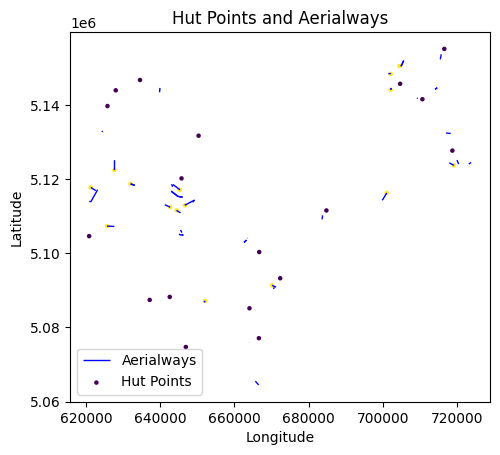

In [102]:
# Plot the hut points and aerialways
fig, ax = plt.subplots()

goods_aerialways.plot(ax=ax, color='blue', linewidth=1, label='Aerialways')
merged_df.plot(ax=ax, c=merged_df['supply_aerialway'], markersize=5, label='Hut Points')

plt.legend()
plt.title('Hut Points and Aerialways')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

HELICOPTER

Huts using helicopter for supplying are: Cevedale, Dorigoni, Stivo, Val di Fumo, Boè, Sette Selle, Rosetta, Vioz (Source: SAT)

In [104]:
heli = ['cevedaleglarcher', 'saentsdorigoni', 'stivopmarchetti', 'valdifumo', 'boè', 'setteselle', 'rosettagpedrotti', 'vioz']

def define_helicopter_supply(row):
    if row['standard_name'] in heli:
        return True
    else:
        return False

merged_df['supply_helicopter'] = merged_df.apply(define_helicopter_supply, axis=1)
merged_df['supply_helicopter'].value_counts()


supply_helicopter
False    25
True      8
Name: count, dtype: int64

ROADS

For each hut, use the Point geometry to get the network of roads connected to it. Check the road types: if a car-road is there, I assume it is used for supplying.

In [105]:
# Buffer distance in meters to search for roads near the hut
buffer_dist = 300  # (more than 300 becomes less accurate (gets Stivo which does not have car access))
huts_with_road = {}

merged_df4326 = merged_df.to_crs(epsg=4326) # OSMnx uses WGS84 [degrees] 
for idx, hut in merged_df4326.iterrows():
    hut_point = hut.geometry

    # Get network of roads within a certain distance from the hut's location
    roads_gdf = ox.features.features_from_point(
        (hut_point.y, hut_point.x),
        tags={'highway': True},  # Fetch all roads with 'highway' tag
        dist=buffer_dist
    )

    # Filter vehicle roads (OSM docs key:highway)
    roads_for_vehicles = ['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'unclassified', 'residential', 'service', 'track'] # track=forestale/agricola
    vehicle_roads = roads_gdf[roads_gdf['highway'].isin(roads_for_vehicles)]
    
    if not vehicle_roads.empty:
      huts_with_road[hut['standard_name']] = vehicle_roads['highway'].unique()

for idx, row in merged_df.iterrows():
    if row['standard_name'] in huts_with_road:
        merged_df.at[idx, 'supply_road'] = True
    else:
        merged_df.at[idx, 'supply_road'] = False


Most of them are of 'track' type which represents strade forestali, which makes sense.

In [106]:
# Combine all supply modes in a single column
def combine_supply_modes(row):
    supply_mode = []
    if row['supply_aerialway']:
        supply_mode.append('aerialway')
    if row['supply_helicopter']:
        supply_mode.append('helicopter')
    if row['supply_road']:
        supply_mode.append('vehicle')
    elif supply_mode == []:
        supply_mode.append('foot')
        
    return supply_mode

merged_df['CR_SU_01'] = merged_df.apply(combine_supply_modes, axis=1)
merged_df['CR_SU_01'].value_counts()

## Accessibility
Sources: OSM (lifts), PAT (trails), SAT (remoteness categories)

Criteria:
- type of accesses
- number of accesses 
- remoteness


CR_AC_01. TYPE OF ACCESS

-> Lifts

From looking in QGIS: there are 3 types of geometries (point, linestring and polygon). Points and polygons are the stations. However, not all lifts have a marked station, so for analysis it may be better to use the linestring (as done with goods aerialways).

I will distinguish between two types of access by lift:
- huts directly accessible via lift (within a 500m (~ 10min) radius from the hut)
- huts with facilitated access thanks to a lift (within a 2.3km radius from the hut)

In [108]:
lifts_aerialways = gpd.read_file('../data/others/lifts_aerialways.geojson')
lifts_aerialways = lifts_aerialways.to_crs(merged_df.crs)

In [109]:
def get_lift_ids_within_buffer(hut_buffer):
    lifts_aerialways_linestring = lifts_aerialways[lifts_aerialways.geometry.type == 'LineString']
    intersecting_lifts = lifts_aerialways_linestring[lifts_aerialways_linestring.intersects(hut_buffer)]
    if not intersecting_lifts.empty:
        # Return all the lift IDs that intersect within the 2300m buffer
        return set(intersecting_lifts['id'])
    else:
        return None

# Directly accessible via lift
merged_df['buffer_500'] = merged_df.geometry.buffer(500)
merged_df['lift_ids_within_500m'] = merged_df['buffer_500'].apply(get_lift_ids_within_buffer)
merged_df = merged_df.drop(columns=['buffer_500'])

# Simplified accessibility via lift
merged_df['buffer_2300'] = merged_df.geometry.buffer(2300)
merged_df['lift_ids_within_2300m'] = merged_df['buffer_2300'].apply(get_lift_ids_within_buffer)
merged_df = merged_df.drop(columns=['buffer_2300'])


For simplicity, for the moment I do not consider the difficulty of the itinerary connecting the lift to the hut. This because the a distance of 2km does not allow much variablity, and the presence of the lift already makes access easier. Note that I checked all the lifts are actually connected to the hut.

In [110]:
merged_df[merged_df['lift_ids_within_500m'].notna()]

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,geometry,acquedotto,sorgente,superficiale,...,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04,supply_aerialway,supply_helicopter,supply_road,CR_SU_01,lift_ids_within_500m,lift_ids_within_2300m
9,ciampediè,CIAMPEDIE',B,Alp,25,1993,POINT (704674.062 5145698.588),1.0,0.0,0,...,"[public_electricity, gas]",2,0.0,public_electricity,False,False,True,[vehicle],"{30792512, 30791793, 30792355, 151641974}","{30792512, 30792482, 30792355, 30792484, 30791..."
13,grostèggraffer,GIORGIO GRAFFER AL GROSTE',C,Alp,70,2261,POINT (645717.304 5120189.926),0.0,1.0,0,...,"[public_electricity, gas]",2,0.0,gasolio,False,False,True,[vehicle],"{42447792, 47405266, 327015525}","{27176128, 327015525, 42447792, 47405266, 3270..."


In [111]:
merged_df[merged_df['lift_ids_within_2300m'].notna()]

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,geometry,acquedotto,sorgente,superficiale,...,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04,supply_aerialway,supply_helicopter,supply_road,CR_SU_01,lift_ids_within_500m,lift_ids_within_2300m
5,boè,BOE',D,Alp,80,2871,POINT (716585.416 5155102.852),0.0,0.0,misto,...,"[public_electricity, gas, solar_thermal]",3,0.0,gasolio,False,True,False,[helicopter],None,{4702284}
9,ciampediè,CIAMPEDIE',B,Alp,25,1993,POINT (704674.062 5145698.588),1.0,0.0,0,...,"[public_electricity, gas]",2,0.0,public_electricity,False,False,True,[vehicle],"{30792512, 30791793, 30792355, 151641974}","{30792512, 30792482, 30792355, 30792484, 30791..."
13,grostèggraffer,GIORGIO GRAFFER AL GROSTE',C,Alp,70,2261,POINT (645717.304 5120189.926),0.0,1.0,0,...,"[public_electricity, gas]",2,0.0,gasolio,False,False,True,[vehicle],"{42447792, 47405266, 327015525}","{27176128, 327015525, 42447792, 47405266, 3270..."
14,mandroncittàditrento,"MANDRON ""CITTA' DI TRENTO""",D,Alp,89,2445,POINT (621213.949 5117752.751),0.0,0.0,torr-lago,...,"[hydroelectric, gas]",2,25.0,elettrico,True,False,False,[aerialway],None,"{32873521, 823434783}"
19,rodadivael,RODA DI VAEL,C,Alp,60,2282,POINT (702109.109 5144095.471),1.0,0.0,0,...,"[cogenerator, photovoltaic, gas]",3,61.4,renewable_option,True,False,False,[aerialway],None,{4699599}
20,rosettagpedrotti,"ROSETTA ""GIOVANNI PEDROTTI""",C,Alp,78,2578,POINT (718762.299 5127676.973),0.0,0.0,fusione,...,"[cogenerator, gas]",2,40.0,elettrico,False,True,False,[helicopter],None,"{39275726, 39275727}"
31,vioz,"VIOZ ""MANTOVA""",E,Alp,60,3531,POINT (625753.000 5139701.000),0.0,0.0,fusione,...,"[cogenerator, gas]",2,80.0,NaN,False,True,False,[helicopter],None,{181081515}


-> Public roads
Use the categoria_PAT column (if "Escurs" then is accessible by car for visitors)

In [112]:
merged_df['car_access'] = merged_df['categoria_PAT'].apply(lambda x: True if x == 'Escurs' else False)

-> Hiking trails
- number of arrival trails

In [113]:
# Buffer hut points by 300 meters and check intersections with trails_gdf
trails_gdf = gpd.read_file('../data/trails/Sentieri_della_SAT.shp')
trails_gdf = trails_gdf.to_crs(merged_df.crs)

# Create a new column 'arrival_trails' to store the names of intersecting trails
merged_df['arrival_trails'] = None

for idx, row in merged_df.iterrows():
    hut_buffer = row['geometry'].buffer(300)
    intersecting_trails = trails_gdf[trails_gdf.intersects(hut_buffer)]
    trail_names = list(intersecting_trails['numero'].unique())
    if trail_names:
        merged_df.at[idx, 'arrival_trails'] = trail_names
    else:
        merged_df.at[idx, 'arrival_trails'] = None

In [114]:
# Combine in a single column
def combine_accesses(row):
    access_mode = []
    if row['car_access']:
        access_mode.append('car')
    if row['arrival_trails']:
        access_mode.append('trail')
    if row['lift_ids_within_500m']:
        access_mode.append('lift_500m')
    if row['lift_ids_within_2300m']:
        access_mode.append('lift_2300m')
    return access_mode

merged_df['CR_AC_01'] = merged_df.apply(combine_accesses, axis=1)

CR_AC_02. NUMBER OF ACCESSES

In [115]:
# Count distinct modes of access (e.g. only car, etc.)
merged_df['CR_AC_02'] = merged_df['CR_AC_01'].apply(len)

CR_AC_03. REMOTENESS

Assessed using the categoria_CAISAT column. This consists of a classification (for the summer season) in 5 classes (A, B, C, D, E) based on **ease of access for hikers** and **ease of access for supplying**. (Regolamento strutture ricettiva del Club Alpino Italiano, p. 7)

- A: rifugi raggiungibili dalla clientela con auto privata o con massimo 10 minuti a piedi dal parcheggio. Sono incluse anche situazioni dove il cliente raggiunge il rifugio (o le immediate vicinanze) pagando un ticket. 
- B: rifugi raggiungibili con impianto a fune, o nelle strette vicinanze (entro i 10 minuti a piedi dall’arrivo dell’impianto); 
- C, D, E: varia in base a ore di cammino (x escursionista) da tabella CAI (vedi Regolamento). Per quanto riguarda il mezzo di trasporto dei rifornimenti/attrezzature, si assume che il costo in elicottero è il più elevato mentre la teleferica ha un costo una tantum ed ammortizzabile su più anni.

This can be easily converted to numbers from 1 (least remote) to 5 (most remote).


In [116]:
conversion_dict = {
    'A':1,
    'B':2,
    'C':3,
    'D':4,
    'E':5, 
}

# uniform values
merged_df['categoria_CAISAT'] = merged_df['categoria_CAISAT'].str.strip().str.upper()
merged_df['CR_AC_03'] = merged_df['categoria_CAISAT'].map(conversion_dict)

## Hospitality
Sources: SAT's archive

Criteria:
- overnight capacity
- seasonal affluence


CR_HO_01. OVERNIGHT CAPACITY

In [117]:
merged_df['CR_HO_01'] = merged_df['posti_letto']

CR_HO_02. SEASONAL OVERNIGHT STAYS (2022)

Extract from sat_pernottamenti.csv


In [118]:
pernottamenti = pd.read_csv('../data/others/sat_pernottamenti.csv')
pernottamenti['standard_name'] = pernottamenti['rifugio'].apply(standardize_name)
merged_df['CR_HO_02'] = merged_df.merge(pernottamenti[['standard_name', '2022']], on='standard_name', how='left')['2022']

# Manually set mis-matched names
merged_df.loc[merged_df['standard_name'] == 'casarotalciola', 'CR_HO_02'] = 102
merged_df.loc[merged_df['standard_name'] == 'fftucketteqsella', 'CR_HO_02'] = 4883
merged_df.loc[merged_df['standard_name'] == 'saentsdorigoni', 'CR_HO_02'] = 2283
merged_df.loc[merged_df['standard_name'] == 'stavelfdenza', 'CR_HO_02'] = 903
merged_df.loc[merged_df['standard_name'] == 'vioz', 'CR_HO_02'] = 1318
merged_df.loc[merged_df['standard_name'] == 'xiiapostoliflligarbari', 'CR_HO_02'] = 1100

## Select only criterias, name and geometry

In [120]:
criteria_cols = [col for col in merged_df.columns if 'CR_' in col]
alternatives_gdf = merged_df[['standard_name', 'geometry'] + criteria_cols]

In [121]:
alternatives_gdf.head(5)

,standard_name,geometry,CR_WA_01,CR_WA_02,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04,CR_SU_01,CR_AC_01,CR_AC_02,CR_AC_03,CR_HO_01,CR_HO_02
0,alpepozzavlancia,POINT (666584.351 5077095.370),spring,40.0,"[generator, photovoltaic, gas]",3,41.8,gasolio,[vehicle],[trail],1,3,50,1084.0
1,altissimodchiesa,POINT (646874.183 5074717.942),spring,30.0,"[generator, photovoltaic, gas]",3,22.5,renewable_option,[vehicle],[trail],1,3,35,401.0
2,antermoia,POINT (704489.000 5150499.000),torr-lago,18.0,"[cogenerator, photovoltaic, gas]",3,61.4,gasolio,"[aerialway, vehicle]",[trail],1,4,61,4002.0
3,bindesipprati,POINT (666672.806 5100323.693),aqueduct,NaN,"[public_electricity, gas]",2,0.0,public_electricity,[vehicle],"[car, trail]",2,1,0,0.0
4,boccaditratnpernici,POINT (637133.000 5087416.000),spring,20.0,"[generator, photovoltaic, gas]",3,41.2,renewable_option,[vehicle],[trail],1,3,28,470.0


# Convert qualitative data
Qualitative columns like CR_WA_01 (water source) need to be converted in quantitative data. 

I defined some scoring systems based on existing literature. The main principle is environmental sustainability.

|criteria|description|conversion|cost/benefit*|
|---|---|---|---|
|**Type of water source**|string|Score based on reliability. From least to most reliable: nosource (0), fusion (glacier/snow) (1), lake/river (2), spring (3), public water (4).|benefit|
|**Type of energy source**|list of strings|Score based on environmental sustainability. From least to most sustainable: gpl and/or (co)generator (1), public electricity (2), renewables (photovoltaic, solar-thermal, hydroelectric) (3) → final score is the mean of all sources for the hut.|benefit|
|**Type of heating**|string|Score based on environmental sustainability. From least to most sustainable: gas (1), renewable_option* (2), electric (3), public_electricity (4)|benefit|
|**Mode of supplying**|list of strings|Score based on environmental sustainability. From least to most sustainable: helicopter (1), vehicle (2), foot or aerialway (3). → final score is the mean of all modes for the hut (same as energy sources).|benefit|
|**Type of accesses**|list of strings|Score based on difficulty of access.  From easier to harder access: public road (1), lifts (2), hiking trails (3). → final score is the mean of all accesses for the hut (same as above).|cost|

*cost/benefit: in MCDM each criteria is either a cost (aim at minimize) or a benefit (aim at maximize).

In [122]:
# Water source
water_source_map = {
    'nosource':0,
    'fusione':1,
    'lago':2,
    'torr-lago':2,
    'lago-torr':2,
    'torr-rio':2,
    'misto':2,
    'spring':3,
    'aqueduct':4
}

for idx, row in alternatives_gdf.iterrows():
    if row['CR_WA_01'] in water_source_map:
        alternatives_gdf.at[idx, 'CR_WA_01'] = water_source_map[row['CR_WA_01']]
    else:
        alternatives_gdf.at[idx, 'CR_WA_01'] = np.nan

In [123]:
# Energy source
energy_source_map = {
    'generator':1,
    'cogenerator':1,
    'gas':1,
    'public_electricity':2,
    'photovoltaic':3,
    'hydroelectric':3,
    'solar_thermal':3,
}

for idx, row in alternatives_gdf.iterrows():
    alternatives_gdf.at[idx, 'CR_EN_01'] = [energy_source_map[s] for s in row['CR_EN_01']]
    # compute the mean
    alternatives_gdf.at[idx, 'CR_EN_01'] = round(sum(alternatives_gdf.at[idx, 'CR_EN_01']) / len(alternatives_gdf.at[idx, 'CR_EN_01']), 2)

In [124]:
# Heating
heating_map = {
    'gasolio':1,
    'renewable_option':2,
    'elettrico':3,
    'public_electricity':4,
}

for idx, row in alternatives_gdf.iterrows():
    if row['CR_EN_04'] in heating_map:
        alternatives_gdf.at[idx, 'CR_EN_04'] = heating_map[row['CR_EN_04']]
    else:
        alternatives_gdf.at[idx, 'CR_EN_04'] = np.nan

In [125]:
# Supplying
supply_map = {
    'helicopter':1,
    'vehicle':2,
    'aerialway':3,
    'foot':3
}

for idx, row in alternatives_gdf.iterrows():
    alternatives_gdf.at[idx, 'CR_SU_01'] = [supply_map[s] for s in row['CR_SU_01']]
    # compute the mean
    alternatives_gdf.at[idx, 'CR_SU_01'] = round(sum(alternatives_gdf.at[idx, 'CR_SU_01']) / len(alternatives_gdf.at[idx, 'CR_SU_01']), 2)


In [126]:
# Access type
access_map = {
    'car':1,
    'lift_500m':2,
    'lift_2300m':3,
    'trail':4
}

for idx, row in alternatives_gdf.iterrows():
    alternatives_gdf.at[idx, 'CR_AC_01'] = [access_map[s] for s in row['CR_AC_01']]
    # compute the mean
    alternatives_gdf.at[idx, 'CR_AC_01'] = round(sum(alternatives_gdf.at[idx, 'CR_AC_01']) / len(alternatives_gdf.at[idx, 'CR_AC_01']), 2)

In [127]:
# check Nans (pymcdm does not accept NaNs)
alternatives_gdf.isna().sum()

standard_name     0
geometry          0
CR_WA_01          0
CR_WA_02         11
CR_EN_01          0
CR_EN_02          0
CR_EN_03          0
CR_EN_04          2
CR_SU_01          0
CR_AC_01          0
CR_AC_02          0
CR_AC_03          0
CR_HO_01          0
CR_HO_02          0
dtype: int64

In [128]:
# CR_WA_02 is the water storage capacity. I will simply replace NaNs with 0
alternatives_gdf.loc[alternatives_gdf['CR_WA_02'].isna(), 'CR_WA_02'] = 0

# CR_EN_04 is the heating type. I will simply replace NaNs with 0
alternatives_gdf.loc[alternatives_gdf['CR_EN_04'].isna(), 'CR_EN_04'] = 0

# Analysis
Using [pymcdm](https://pymcdm.readthedocs.io/en/master/readme_link.html#usage-example) library.

Things to define:
- MCDM method
- normalization technique
- weights


In [129]:
alts = alternatives_gdf.drop(columns=['standard_name', 'geometry', 'CR_HO_01', 'CR_HO_02'])
alts = alts.apply(pd.to_numeric, errors='coerce')
alts = alts.to_numpy()  

## Example with TOPSIS 
(following [example](https://pymcdm.readthedocs.io/en/master/example/Example.html#Using-several-MCDA-methods-for-a-decision-problem))

In [130]:
from pymcdm.methods import TOPSIS
from pymcdm import weights as w

# Define weights 
weights = w.equal_weights(alts)
# Define criteria types (benefit=1 or cost=-1)
types = np.array([1, 1, 1, 1, 1, 1, 1, -1, 1, -1])

# Create object for method (default normalization is min-max norm)
topsis = TOPSIS()

# Apply method (calculate preferences)
pref = topsis(alts, weights, types)

# Create ranking
rank = topsis.rank(pref)

print(pref)
print(rank)


[0.35674334 0.37407189 0.33700634 0.53583681 0.37454546 0.34535982
 0.41296379 0.41951676 0.20190417 0.53193183 0.36715755 0.37268265
 0.41064734 0.51791562 0.44009532 0.54446658 0.35567089 0.53583681
 0.42014429 0.49556003 0.32817432 0.34547271 0.37329837 0.38827868
 0.35435768 0.33482015 0.31561052 0.41476598 0.36780626 0.27028254
 0.36595513 0.21441126 0.36620682]
[22.  15.  27.   2.5 14.  26.  11.   9.  33.   4.  19.  17.  12.   5.
  7.   1.  23.   2.5  8.   6.  29.  25.  16.  13.  24.  28.  30.  10.
 18.  31.  21.  32.  20. ]


For the TOPSIS method, the most significant value (the closer to 1) of the preference means a better alternative.

We can create the ranking (assign a number to each hut which represents its position in the ranking (1 is the best)). 

In [131]:
# Create a DataFrame with standard_name, rank position, and preference score
ranking_df = pd.DataFrame({
    'standard_name': alternatives_gdf['standard_name'],
    'rank': rank,
    'preference_score': pref
})

ranking_df = ranking_df.sort_values(by='rank')
ranking_df

,standard_name,rank,preference_score
15,montecalinosanpietro,1.0,0.544467
17,paludei,2.5,0.535837
3,bindesipprati,2.5,0.535837
9,ciampediè,4.0,0.531932
13,grostèggraffer,5.0,0.517916
19,rodadivael,6.0,0.495560
14,mandroncittàditrento,7.0,0.440095
18,peller,8.0,0.420144
7,casarotalciola,9.0,0.419517
27,valdambiezsagostini,10.0,0.414766


### weights comparison
Now i try to compare different weighting approaches using TOPSIS: equal weights, entropy weights, standard deviation weights and custom weights defined by me.

In [132]:
# Define weights 
custom_weights = np.array([0.15, 0.10, 0.20, 0.05, 0.05, 0.05, 0.15, 0.05, 0.05, 0.15])
assert custom_weights.sum() == 1, f"Weights do not sum to 1: {custom_weights.sum()}"

weights_list = [
    w.equal_weights(alts), 
    w.entropy_weights(alts), 
    w.standard_deviation_weights(alts),
    custom_weights]
weights_names = ['equal', 'entropy', 'std_dev', 'custom']

# Define criteria types (benefit=1 or cost=-1)
types = np.array([1, 1, 1, 1, 1, 1, 1, -1, 1, -1]) # type of access and remoteness are costs

# Create object for method (default normalization is min-max norm)
topsis = TOPSIS()

prefs = []
ranks = []
for weights in weights_list:
    # Apply method (calculate preferences)
    pref = topsis(alts, weights, types)
    rank = topsis.rank(pref)

    prefs.append(pref)
    ranks.append(rank)


In [133]:
a = alternatives_gdf['standard_name']
pref_df = pd.DataFrame(zip(*prefs), columns=weights_names, index=a).round(3)
pref_df.sort_values('custom', ascending=False)

,equal,entropy,std_dev,custom
standard_name,,,,
montecalinosanpietro,0.544,0.427,0.009,0.598
carèaltodongari,0.413,0.376,0.022,0.577
rodadivael,0.496,0.439,0.057,0.554
paludei,0.536,0.500,0.010,0.541
bindesipprati,0.536,0.500,0.010,0.541
ciampediè,0.532,0.500,0.009,0.517
casarotalciola,0.420,0.377,0.026,0.513
stavelfdenza,0.388,0.373,0.009,0.512
grostèggraffer,0.518,0.500,0.489,0.500


In [134]:
rank_df = pd.DataFrame(zip(*ranks), columns=weights_names, index=a).astype('int')
rank_df

,equal,entropy,std_dev,custom
standard_name,,,,
alpepozzavlancia,22,20,11,19
altissimodchiesa,15,13,17,16
antermoia,27,27,10,26
bindesipprati,2,3,26,4
boccaditratnpernici,14,11,14,17
boè,26,26,6,29
carèaltodongari,11,15,22,2
casarotalciola,9,14,20,7
cevedaleglarcher,33,28,13,32


Compare rankings for the different techniques

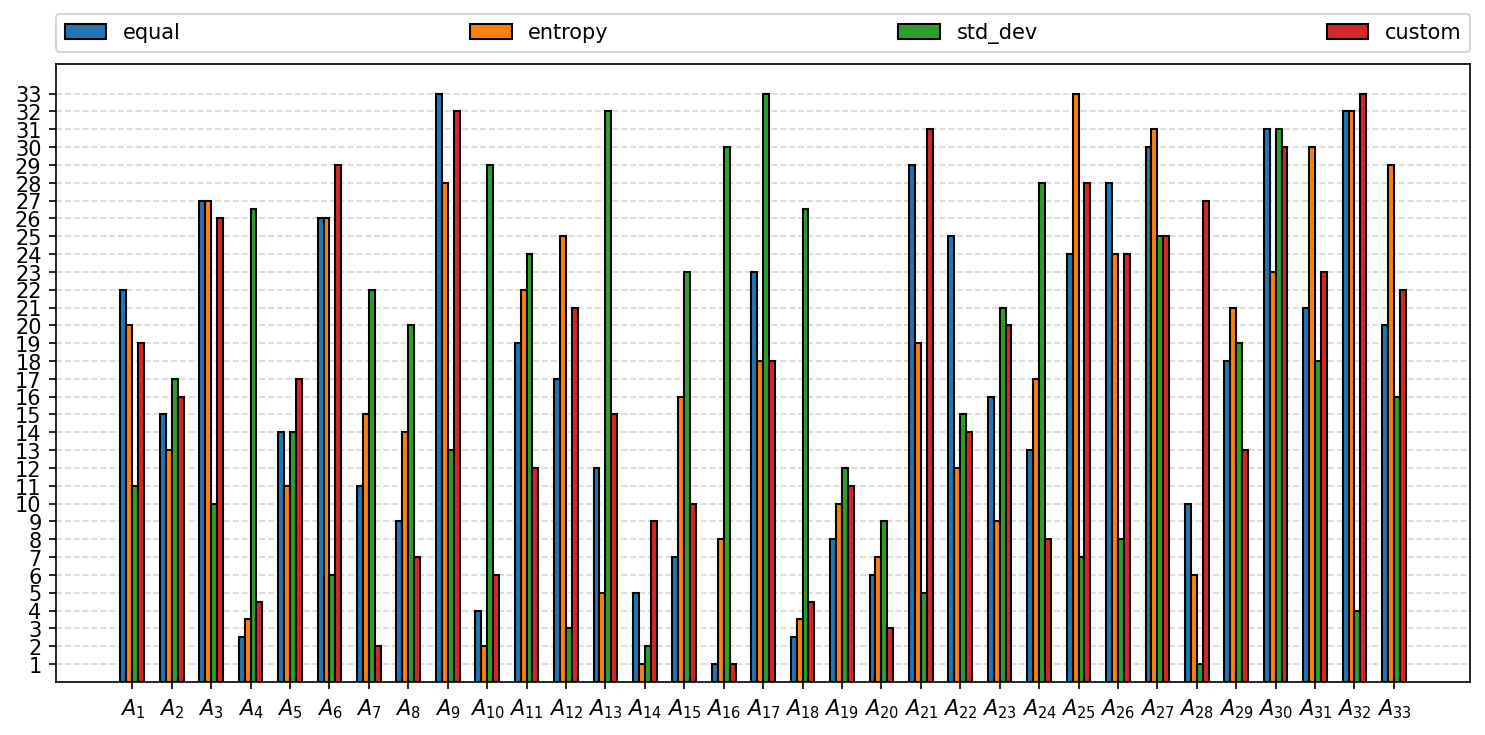

In [135]:
from pymcdm import visuals

fig, ax = plt.subplots(figsize=(10,5), dpi=150, tight_layout=True)
visuals.ranking_bar(ranks, labels=weights_names, ax=ax, spacing=0.2)
plt.show()


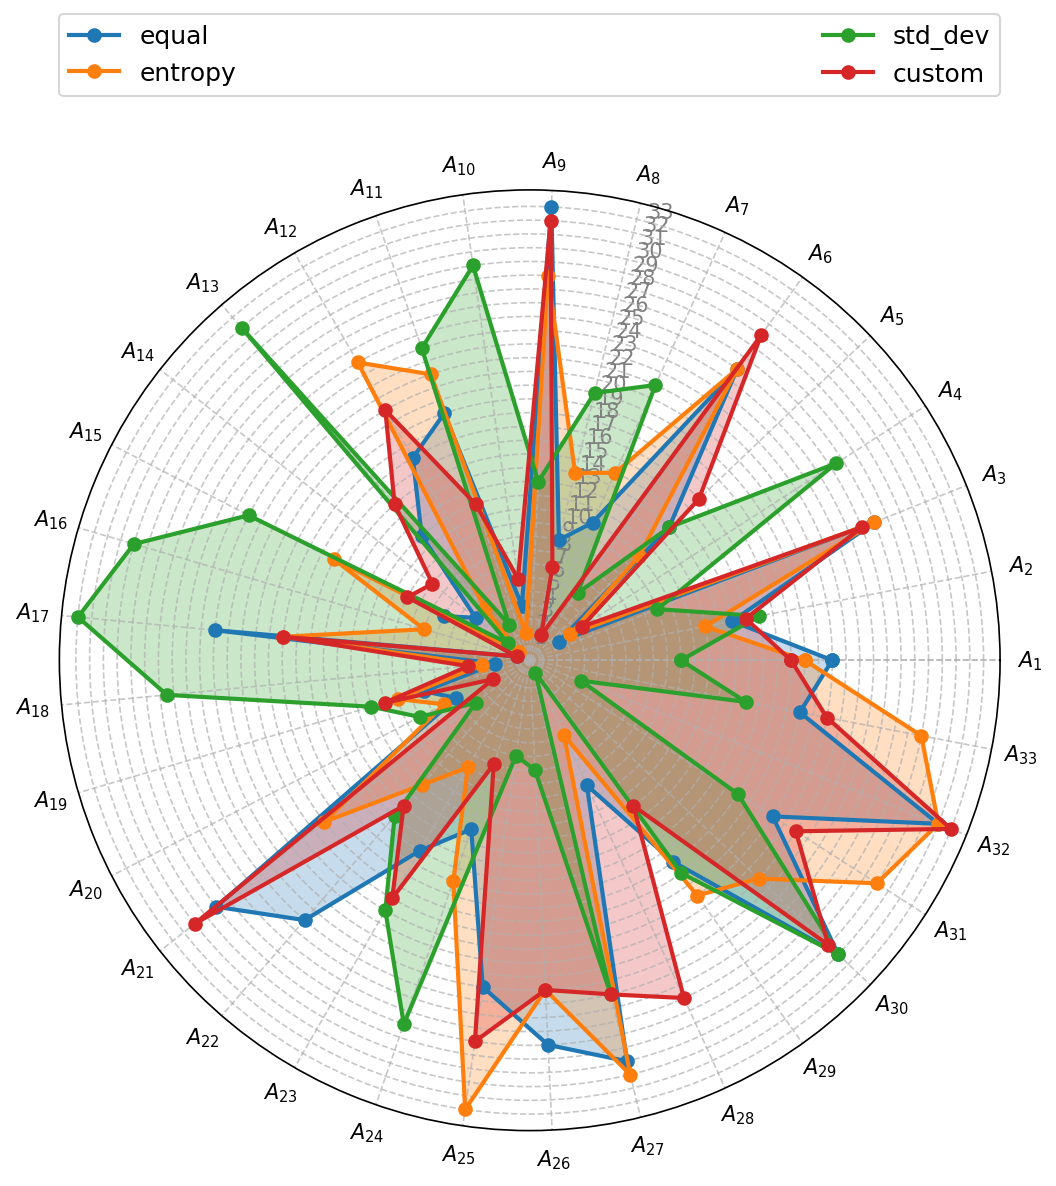

In [136]:
fig, ax = plt.subplots(figsize=(8,8), dpi=150, tight_layout=True, subplot_kw=dict(projection='polar'))
visuals.polar_plot(ranks, labels=weights_names, legend_ncol=2, ax=ax)
plt.show()


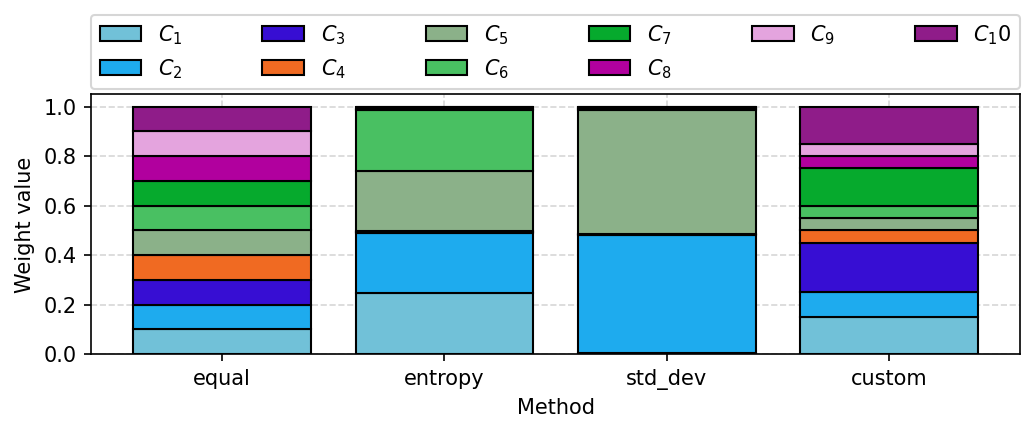

In [137]:
# Visualize criteria weights
fig, ax = plt.subplots(figsize=(7, 3), dpi=150, tight_layout=True)
colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(len(criteria_cols))]
visuals.weights_plot(weights_list,
                     xticklabels=weights_names,
                     colors=colors,
                     legend_ncol=6,
                     ax=ax)

plt.show()


## Analysis with different methods
By the literature review of MCDM methods, candidate models to adopt are:

American school:
- **TOPSIS**: produces a ranking based on a synthesized index (score from 0 to 1). The ranking is computed according to the closeness score to *ideal* and distance to anti-ideal. So in this case the preference function to be chosen is the type of distance (Euclidean, Manhattan, etc.).

    --> output: preference scores (better alternatives have *higher* values).

- **VIKOR**: similar to TOPSIS, also produces a ranking based on the closeness score (positive values) to the *best option*. This means it aims at finding a compromise solution closest to ideal but considering worst-performing criteria (avoids solutions that may be excellent in one criterion but poor in another). Uses Euclidean distance. 

    --> output: preference scores (better alternatives have *smaller* values).

- **COPRAS**: provides a ranking based on the *utility degree* (expressed in %) of each alternative (computed using relative significance: combination of costs and benefits criteria). Higher utility means better alternative. Simpler method than the others.

    --> output: preference scores (better alternatives have *higher* values).

European school:
- **PROMETHEE II**: model based on pairwise comparison (outranking). For each criterion, weights and a preference function are defined. The *preference function* for the i-th criterion is computed for each alternative and the weighted sum over all criteria defines the *aggregated preference index* of alternative a over alternative b. Using *outranking flows* it is possible to obtain a partial ranking (PROMETHEE I) or a complete ranking (PROMETHEE II) based on such pairwise preference/dominance relations.


In [138]:
from pymcdm.methods import TOPSIS, VIKOR, COPRAS
from pymcdm import weights as w
from pymcdm import visuals

# Define weights 
custom_weights = np.array([0.15, 0.10, 0.20, 0.05, 0.05, 0.05, 0.15, 0.05, 0.05, 0.15])
assert custom_weights.sum() == 1, f"Weights do not sum to 1: {custom_weights.sum()}"

weights_list = [
    w.equal_weights(alts),  
    custom_weights]
weights_names = ['equal', 'custom']

# Define criteria types (benefit=1 or cost=-1)
types = np.array([1, 1, 1, 1, 1, 1, 1, -1, 1, -1]) # type of access and remoteness are costs

# Define methods
methods_list = [
    TOPSIS(),
    VIKOR(),
    COPRAS()
]
methods_names = ['TOPSIS', 'VIKOR', 'COPRAS']

prefs = []
ranks = []
confs = []

for i, method in enumerate(methods_list):
    for y, weights in enumerate(weights_list):
        # Apply method (calculate preferences)
        pref = method(alts, weights, types)
        rank = method.rank(pref)

        prefs.append(pref)
        ranks.append(rank)
        confs.append(methods_names[i] + '_' + weights_names[y])

In [139]:
a = alternatives_gdf['standard_name']
pref_df = pd.DataFrame(zip(*prefs), columns=confs, index=a).round(3)
rank_df = pd.DataFrame(zip(*ranks), columns=confs, index=a).astype('int')

### Rank analysis
The correlation between results obtained with different configurations is a measure of similarity between rankings. I use Spearman rank correlation. 

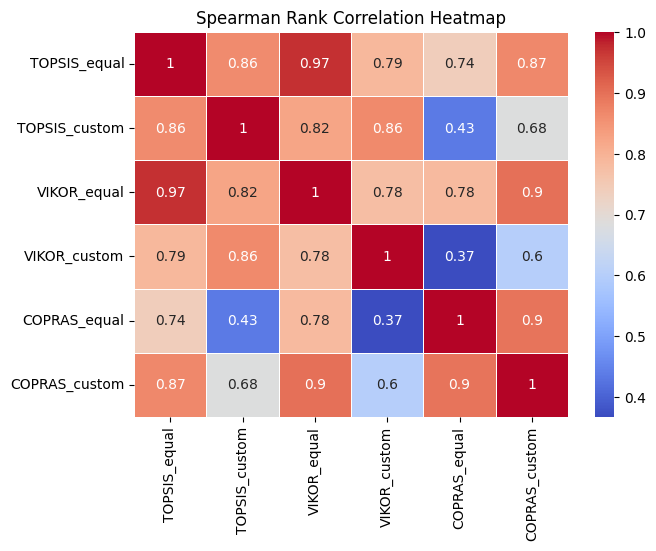

In [140]:
import scipy.stats as stats
import seaborn as sns

# Compute the Spearman rank correlation matrix
corr_matrix = np.zeros((len(ranks), len(ranks)))
for i in range(len(ranks)):
    for j in range(len(ranks)):
        corr_matrix[i, j], _ = stats.spearmanr(ranks[i], ranks[j])

# Convert to DataFrame
df_corr = pd.DataFrame(corr_matrix, index=confs, columns=confs)

# Plot the correlation matrix heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', cbar=True, linewidths=.5)
plt.title('Spearman Rank Correlation Heatmap')
plt.show()


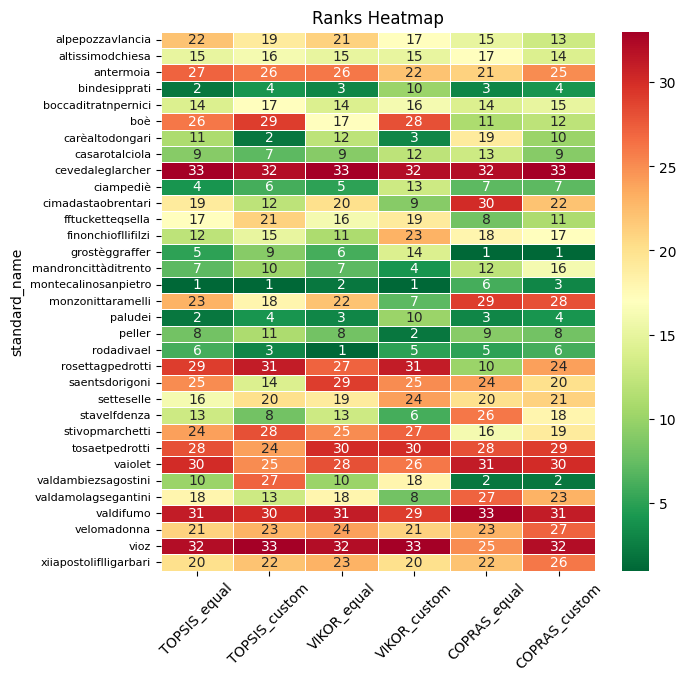

In [141]:
# Plot heatmap for the ranks
plt.figure(figsize=(7, 7))
ax = sns.heatmap(rank_df, annot=True, cmap='RdYlGn_r', cbar=True, linewidths=.5)

ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelrotation=45)
plt.title('Ranks Heatmap')
plt.show()


#### Rank standard deviation

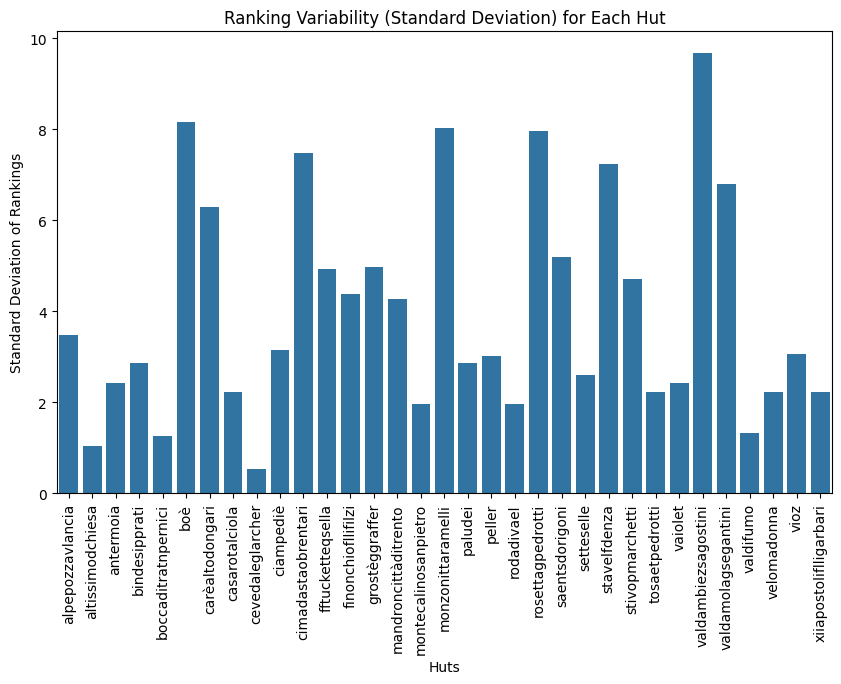

In [142]:
# Calculate standard deviation among the columns for each hut
rank_std = rank_df.std(axis=1)

# Add standard deviation as a new column
rank_df['Rank_StdDev'] = rank_std

# Plot standard deviation
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=rank_df.index, y=rank_std)
plt.xticks(rotation=90)
plt.title('Ranking Variability (Standard Deviation) for Each Hut')
plt.ylabel('Standard Deviation of Rankings')
plt.xlabel('Huts')
plt.show()


### Preference score distance
The distance between preference scores indicates how far apart the preferences are among the different configurations.

Note: in VIKOR lower preference scores indicate a better alternative (contrary of TOPSIS, COPRAS).

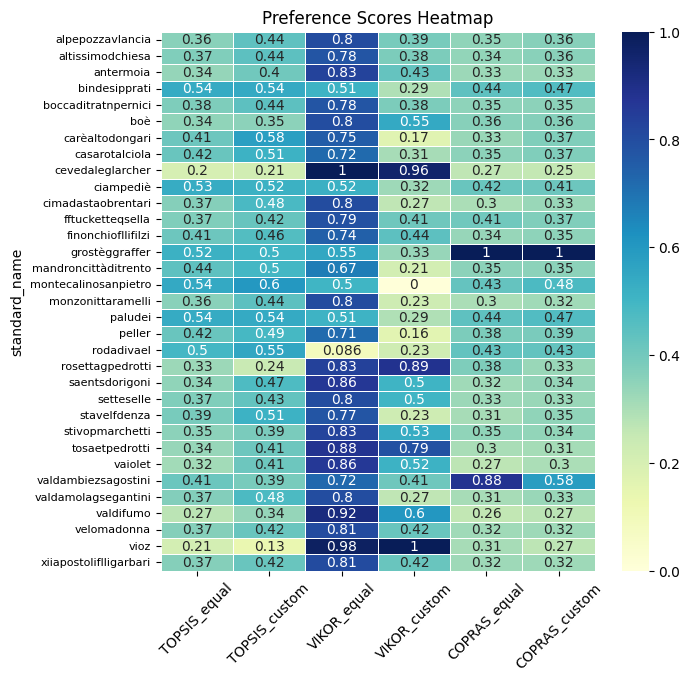

In [143]:
# Plot heatmap for the preference scores
plt.figure(figsize=(7, 7))
ax = sns.heatmap(pref_df, annot=True, cmap='YlGnBu', cbar=True, linewidths=.5)

ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelrotation=45)
plt.title('Preference Scores Heatmap')
plt.show()


Some comments:
- About preference scores: must be careful in comparing preference scores among methods because the scale differs. In VIKOR, a lower score indicates a better alternative, whereas in COPRAS and TOPSIS a lower score means a worse alternative. Comparing rankings is more reliable.

- About rankings: many huts are consistent in their ranking among the various configurations. This can be observed both from the rank heatmap, and from the pairwaise *rank correlation heatmap*.

### PROMETHEE II 
Method from the European school, it produces a complete ranking (equivalent to the above results), but is based on outranking flow (comparative approach instead of absolute scoring) and requires extra information about criteria (preference functions). 

Thus, before applying the model I have to define a preference function (and preference thresholds) for each criteria, based on the type of measure and ranges.
A separate function for each criteria is not supported for PROMETHEE on pymcdm, a workaround is: 
1. Apply PROMETHEE I individually for each criterion using the specific preference function and thresholds.
2. Aggregate the positive and negative flows from each criterion to compute the PROMETHEE II scores.

In [144]:
## Checking data to decide preference functions
# water storage capacity
alternatives_gdf['CR_WA_02'].describe()

# energy source types
alternatives_gdf['CR_EN_01'].value_counts()

# number of energy sources
alternatives_gdf['CR_EN_02'].describe()

# power storage capacity
alternatives_gdf['CR_EN_03'].describe()

# heating source 
alternatives_gdf['CR_EN_04'].unique()

# supply mode
alternatives_gdf['CR_SU_01'].describe()

# types of accesses
alternatives_gdf['CR_AC_01'].value_counts()

# number of accesses
alternatives_gdf['CR_AC_02'].value_counts()

CR_AC_02
1    23
2     8
3     2
Name: count, dtype: int64

In [145]:
## Set-up
from pymcdm.methods import PROMETHEE_II

# Define weights for each criterion (sum should be 1)
custom_weights = np.array([0.15, 0.10, 0.20, 0.05, 0.05, 0.05, 0.15, 0.05, 0.05, 0.15])
assert custom_weights.sum() == 1, f"Weights do not sum to 1: {custom_weights.sum()}"

# Specify types for each criterion (1 for benefit, -1 for cost)
types = np.array([1, 1, 1, 1, 1, 1, 1, -1, 1, -1]) 

# Define preference functions and thresholds
criteria_config = {
    'water_source': {
        'preference_function': 'level',     # order of pref: 0, 1 < 2, 3 < 4  (no source, fusion < superficial < acqueduct)
        'p_threshold': 1.5,                 # preference only when moving to next pref class
        'q_threshold': 1                    # differences within the same equivalence category do not show preference
    },
    'water_storage_capacity': {
        'preference_function': 'vshape_2',  # favour larger capacity (do not care for small differences)
        'p_threshold': 30,                  # differences of 30 units [m3] or more are treated as meaningful    
        'q_threshold': 15                   # small differences within 15 units are ignored
    },
    'energy_source': {
        'preference_function': 'level',     # divide between non-renewables, public el and renewables
        'p_threshold': 0.75,                # strong preferences are only for scores that span most of a level
        'q_threshold': 0.25                 # small differences within the same category or mixed scores aren’t prioritized
    },
    'number_of_sources': {
        'preference_function': 'vshape',    # reward alternatives with higher source counts (reliability)
        'p_threshold': 1,                   # Preference with a full unit increase 
        'q_threshold': None     
    },
    'power_storage_capacity': {
        'preference_function': 'vshape_2',  # favour larger capacity (do not care for small differences)
        'p_threshold': 40,     
        'q_threshold': 20     
    },
    'heating_source': {
        'preference_function': 'ushape',    # gas < electric / public electricity / ren option
        'p_threshold': None,   
        'q_threshold': 1                    
    },
    'supply_mode': {
        'preference_function': 'level', 
        'p_threshold': 1,   
        'q_threshold': 0.5     
    },
    'types_of_access': {
        'preference_function': 'level',     # easy(car) < moderate (lifts) < hiking (only)
        'p_threshold': 0.50,   
        'q_threshold': 0.25     
    },
    'number_of_accesses': {
        'preference_function': 'vshape',    # favour more access points
        'p_threshold': 1,     
        'q_threshold': None     
    },
    'remoteness': {
        'preference_function': 'ushape',
        'p_threshold': None,      
        'q_threshold': 1       
    }
}


In [146]:
## Apply method
# Initialize positive and negative flow accumulators
positive_flows = np.zeros(alts.shape[0])
negative_flows = np.zeros(alts.shape[0])

# Calculate PROMETHEE I flows for each criterion separately
for idx, (criterion, config) in enumerate(criteria_config.items()):
    # Initialize PROMETHEE II with the current criterion's preference function
    promethee = PROMETHEE_II(config['preference_function'])
    
    # Positive and negative flows array for idx criterion
    pos_flow, neg_flow = promethee(alts[:, [idx]], np.array([weights[idx]]), np.array([types[idx]]), 
                                   p=np.array([config['p_threshold']]), q=np.array([config['q_threshold']]), promethee_I=True)
    
    # Weighted sum of positive and negative flows (PROMETHEE I scores)
    positive_flows += pos_flow * weights[idx]
    negative_flows += neg_flow * weights[idx]

# Net outranking flow (PROMETHEE II score)
net_flows = positive_flows - negative_flows # the higher, the better

# Display results
print("PROMETHEE II scores (net flows):")
print(net_flows)

# Rank alternatives based on the net flows (descending order + start rank from 1)
ranked_alternatives = np.argsort(net_flows)[::-1] + 1
rank_df['PROMETHEE_II'] = ranked_alternatives

PROMETHEE II scores (net flows):
[-0.00091758 -0.00279883 -0.00910534  0.02345781 -0.00520833  0.00191354
  0.03373385  0.00434948 -0.04667891  0.01541094  0.00862214 -0.00327344
 -0.0036125   0.00598906  0.01206719  0.04314531 -0.00123516  0.02345781
  0.01811328  0.01874362 -0.04110078  0.01356589  0.00790898  0.01554922
 -0.00059766 -0.02157891 -0.01449271 -0.01579427  0.00785234 -0.01567474
 -0.00917969 -0.05365703 -0.00897461]
Ranked alternatives (from best to worst): [16  7  4 18 20 19 24 10 22 15 11 23 29 14  8  6 25  1 17  2 12 13  5 33
  3 31 27 30 28 26 21  9 32]


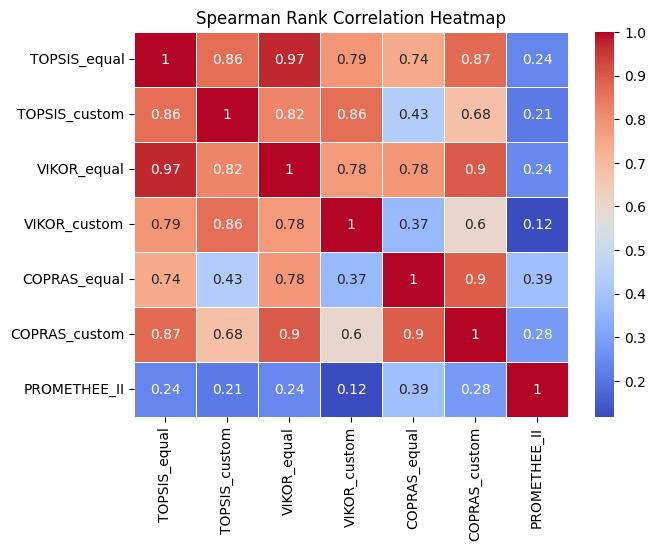

In [148]:
# update plotting lists
ranks.append(ranked_alternatives)
confs.append('PROMETHEE_II')

# Spearman rank correlation matrix
corr_matrix = np.zeros((len(ranks), len(ranks)))
for i in range(len(ranks)):
    for j in range(len(ranks)):
        corr_matrix[i, j], _ = stats.spearmanr(ranks[i], ranks[j])

df_corr = pd.DataFrame(corr_matrix, index=confs, columns=confs)

# Plot the correlation matrix heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', cbar=True, linewidths=.5)
plt.title('Spearman Rank Correlation Heatmap')
plt.show()

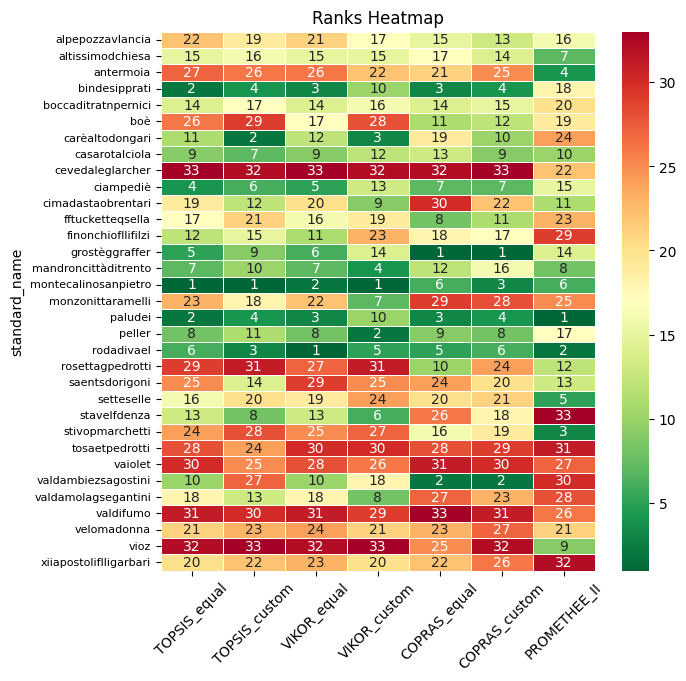

In [152]:
# Plot heatmap for the ranks
plt.figure(figsize=(7, 7))
rank_df.drop(columns='Rank_StdDev', inplace=True)
ax = sns.heatmap(rank_df, annot=True, cmap='RdYlGn_r', cbar=True, linewidths=.5)

ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelrotation=45)
plt.title('Ranks Heatmap')
plt.show()

By the correlation and visualization of the rankings, it appears that PROMETHEE_II provides quite different results. However, some huts are quite consistent with the other methods (e.g. rodadivael and paludei are ranked 2nd and 3rd by PROMETHEE_II, and similarly in the first positions by the rest). 